Francisco José Durá Galiana

# Red simple para predicción de género y tempo

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Leer datos

In [6]:
# Parámetros de extracción de canciones
gtzan_dir = r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Datasets\GTZAN\genres"
data_df = pd.read_csv(r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Scripts\gtzan_clean.csv")
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [9]:
X = np.load('x_gtzan_npy.npy')
y1 = np.load('y1_gtzan_npy.npy')
y2 = np.load('y2_gtzan_npy.npy')

In [10]:
y1 = to_categorical(y1)

## Partición de los datos

In [13]:
y = np.concatenate((y1,y2.reshape(-1,1)),axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [14]:
y1_train = y_train[:,:-1]
y1_test = y_test[:,:-1]
y2_train = y_train[:,-1]
y2_test = y_test[:,-1]

In [15]:
print(X_train.shape, X_test.shape)
print(y1_train.shape, y1_test.shape)
print(y2_train.shape, y2_test.shape)

(15200, 128, 129, 1) (3800, 128, 129, 1)
(15200, 10) (3800, 10)
(15200,) (3800,)


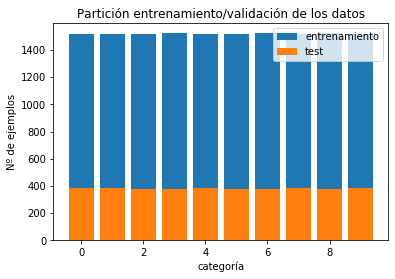

In [16]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y1_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y1_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

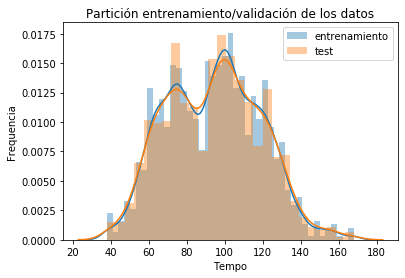

In [17]:
# Histogram for train and test 
sns.distplot(y2_train,label='entrenamiento')
sns.distplot(y2_test, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('Tempo')
plt.ylabel('Frequencia')
plt.legend()
plt.show()

## Construcción del modelo

In [18]:
# Model Definition
class MIR:
    
    def build(num_genres=10):
        input_shape = X_train[0].shape

        inputs = Input(shape=input_shape)
        # Conv Block 1
        x1 = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C1')(inputs)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P1')(x1)
        x1 = Dropout(0.25, name='D1')(x1)

        # Conv Block 2
        x2 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C2')(x1)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P2')(x2)
        x2 = Dropout(0.25, name='D2')(x2)

        # Conv Block 3
        x3 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C3')(x2)
        x3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P3')(x3)
        x3 = Dropout(0.25, name='D3')(x3)

        # Conv Block 4
        x4 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C4')(x3)
        x4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P4')(x4)
        x4 = Dropout(0.25, name='D4')(x4)

        # Conv Block 5
        x5 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C5')(x4)
        x5 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='P5')(x5)
        x5 = Dropout(0.25, name='D5')(x5)

        # MLP
        y = Flatten(name='C_out')(x5)
        y1 = Dense(num_genres, activation='softmax', name="genre")(y)
        y2 = Dense(64, activation='relu', name="FC1")(y)
        y2 = Dense(32, activation='relu', name="FC2")(y2)
        y2 = Dense(1, name="tempo")(y2)

        model = Model(
            inputs=inputs,
            outputs=[y1, y2],
            name="MIR")
        
        return model

In [19]:
model = MIR.build()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 129, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 126, 127, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 63, 63, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 63, 63, 16)   0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_2 (

## Entrenamiento del modelo

In [21]:
losses = {"genre": "categorical_crossentropy",
          "tempo": "mse"}
loss_weights = {"genre": 2.0, "tempo": 0.5}

model.compile(loss=losses, loss_weights=loss_weights,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [22]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)

hist = model.fit(X_train, {"genre":y1_train, "tempo":y2_train},
          batch_size=32, # tamaño del batch de entrenamiento
          epochs=200, # Número de pases
          verbose=1, # Mostrar progreso
          validation_split=0.25,
          callbacks=[tensorboard]) # Seleccionar un 25% de los datos para validación 

Train on 11400 samples, validate on 3800 samples
Epoch 1/200
11400/11400 [==============================] - 7s 636us/step - loss: 1036.9740 - genre_loss: 10.8485 - tempo_loss: 2030.5540 - genre_acc: 0.1021 - tempo_acc: 0.0089 - val_loss: 1221.7795 - val_genre_loss: 3.3052 - val_tempo_loss: 2430.3381 - val_genre_acc: 0.1166 - val_tempo_acc: 0.0026re_loss: 9.3603 - tempo_loss: 5221.7004 - genre_acc: 0.0993 - te - ETA: 4s - loss: 2005.5690 - genre_loss: 9.9757 - te - ETA: 1s - loss: 1290.9457 - genre_loss: 10.7210 - tempo_loss: 2539.0076 - genre_acc: 0.1008 - tempo_acc:  - ETA: 1s - loss: 1248.1958 - genre_loss: 10.7322 - tempo_loss: 2453.4630 - genre_acc: 0.1013 - - ETA: 0s - loss: 1144.0233 - genre_loss: 10.7938 - tempo_loss: 2244.8716 - genre_acc: 
Epoch 2/200
11400/11400 [==============================] - 6s 519us/step - loss: 342.2978 - genre_loss: 10.0099 - tempo_loss: 644.5559 - genre_acc: 0.1005 - tempo_acc: 0.0110 - val_loss: 1391.6932 - val_genre_loss: 2.6373 - val_tempo_loss: 2

11400/11400 [==============================] - 6s 513us/step - loss: 197.9491 - genre_loss: 1.9985 - tempo_loss: 387.9043 - genre_acc: 0.2725 - tempo_acc: 0.0204 - val_loss: 760.0304 - val_genre_loss: 1.9130 - val_tempo_loss: 1512.4088 - val_genre_acc: 0.3276 - val_tempo_acc: 0.0066
Epoch 48/200
11400/11400 [==============================] - 6s 520us/step - loss: 195.8524 - genre_loss: 2.0052 - tempo_loss: 383.6841 - genre_acc: 0.2784 - tempo_acc: 0.0205 - val_loss: 509.0194 - val_genre_loss: 1.8973 - val_tempo_loss: 1010.4498 - val_genre_acc: 0.3066 - val_tempo_acc: 0.0082.7247 - genre_loss: 2.0157 - tempo_loss: 383.3
Epoch 49/200
11400/11400 [==============================] - 6s 521us/step - loss: 195.8040 - genre_loss: 2.0084 - tempo_loss: 383.5742 - genre_acc: 0.2720 - tempo_acc: 0.0219 - val_loss: 567.4356 - val_genre_loss: 1.9307 - val_tempo_loss: 1127.1486 - val_genre_acc: 0.3087 - val_tempo_acc: 0.0087nre_loss: 1.9753 - tempo_loss: 381.7767 - genre_acc: 0.2831 - tempo_acc: 0.02

11400/11400 [==============================] - 6s 519us/step - loss: 180.8049 - genre_loss: 1.9968 - tempo_loss: 353.6225 - genre_acc: 0.2920 - tempo_acc: 0.0217 - val_loss: 556.3147 - val_genre_loss: 1.8387 - val_tempo_loss: 1105.2745 - val_genre_acc: 0.3555 - val_tempo_acc: 0.0076
Epoch 69/200
11400/11400 [==============================] - 6s 524us/step - loss: 177.9990 - genre_loss: 1.9524 - tempo_loss: 348.1884 - genre_acc: 0.3093 - tempo_acc: 0.0246 - val_loss: 657.8134 - val_genre_loss: 1.8551 - val_tempo_loss: 1308.2063 - val_genre_acc: 0.3305 - val_tempo_acc: 0.005861 - genre_loss: 1.9451 - t - ETA: 0s - loss: 178.0676 - genre_loss: 1.9552 - tempo_loss: 348.3146 - genre_acc: 0.3097 - tempo_
Epoch 70/200
11400/11400 [==============================] - 6s 528us/step - loss: 177.1084 - genre_loss: 1.9377 - tempo_loss: 346.4659 - genre_acc: 0.3123 - tempo_acc: 0.0226 - val_loss: 556.6100 - val_genre_loss: 1.8173 - val_tempo_loss: 1105.9510 - val_genre_acc: 0.3442 - val_tempo_acc: 0.

11400/11400 [==============================] - 6s 517us/step - loss: 150.1698 - genre_loss: 1.8998 - tempo_loss: 292.7403 - genre_acc: 0.3261 - tempo_acc: 0.0276 - val_loss: 626.0225 - val_genre_loss: 1.8147 - val_tempo_loss: 1244.7862 - val_genre_acc: 0.3516 - val_tempo_acc: 0.004503 - tempo_loss: 288
Epoch 112/200
11400/11400 [==============================] - 6s 525us/step - loss: 153.8625 - genre_loss: 1.8955 - tempo_loss: 300.1431 - genre_acc: 0.3313 - tempo_acc: 0.0258 - val_loss: 650.4551 - val_genre_loss: 1.7761 - val_tempo_loss: 1293.8057 - val_genre_acc: 0.3755 - val_tempo_acc: 0.0063
Epoch 113/200
11400/11400 [==============================] - 6s 511us/step - loss: 152.4135 - genre_loss: 1.8846 - tempo_loss: 297.2888 - genre_acc: 0.3366 - tempo_acc: 0.0254 - val_loss: 568.0793 - val_genre_loss: 1.7240 - val_tempo_loss: 1129.2626 - val_genre_acc: 0.3853 - val_tempo_acc: 0.0068
Epoch 114/200
11400/11400 [==============================] - 6s 511us/step - loss: 150.8437 - genre_

11400/11400 [==============================] - 6s 523us/step - loss: 130.8627 - genre_loss: 1.8675 - tempo_loss: 254.2556 - genre_acc: 0.3477 - tempo_acc: 0.0318 - val_loss: 680.4506 - val_genre_loss: 1.6984 - val_tempo_loss: 1354.1075 - val_genre_acc: 0.3829 - val_tempo_acc: 0.0047
Epoch 160/200
11400/11400 [==============================] - 6s 528us/step - loss: 131.6861 - genre_loss: 1.8729 - tempo_loss: 255.8807 - genre_acc: 0.3497 - tempo_acc: 0.0304 - val_loss: 590.5010 - val_genre_loss: 1.7220 - val_tempo_loss: 1174.1142 - val_genre_acc: 0.4066 - val_tempo_acc: 0.0063133.4422 - genre_loss: 1.8778 - tempo_loss: 259.3733 - genre_acc: 0.3493 - t - ETA: 1s - loss: 131.2221 - genre_loss: 1.8728 - tempo_loss: 254.9531 - genre_acc: 0. - ETA: 0s - loss: 132.2267 - genre_loss: 1.8741 - tempo_loss: 256.9569 - genre_acc: 0.3514 - tempo_acc: 0.
Epoch 161/200
11400/11400 [==============================] - 6s 527us/step - loss: 131.8326 - genre_loss: 1.8679 - tempo_loss: 256.1937 - genre_acc:

## Resultados

In [65]:
score_test = model.evaluate(X_test, [y1_test, y2_test], verbose=0)
print("\t\t|-----------|-------|")
print("\tGenre\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['genre_acc'][-1], hist.history['genre_loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_genre_acc'][-1], hist.history['val_genre_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[3], score_test[1]))
print("+---------------+-----------+-------+")

print("\t\t|-----------|-------|")
print("\tTempo\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['tempo_acc'][-1], hist.history['tempo_loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_tempo_acc'][-1], hist.history['val_tempo_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[4], score_test[2]))
print("+---------------+-----------+-------+")

		|-----------|-------|
	Genre	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.347   |  1.91 |
| Validacion	|   0.402   |  1.71 |
| Test		|   0.406   |  1.70 |
+---------------+-----------+-------+
		|-----------|-------|
	Tempo	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.033   | 228.09 |
| Validacion	|   0.004   | 1297.21 |
| Test		|   0.004   | 1299.61 |
+---------------+-----------+-------+


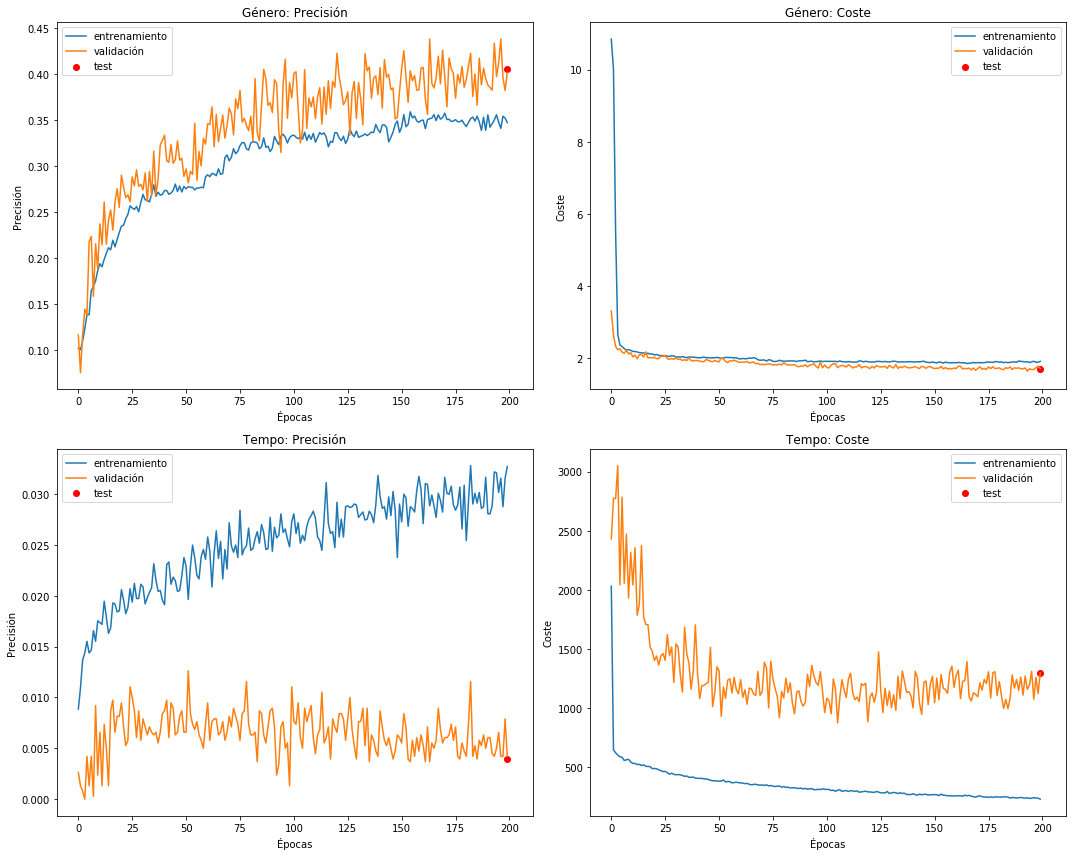

In [66]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.plot(hist.history['genre_acc'], label='entrenamiento')
plt.plot(hist.history['val_genre_acc'], label='validación')
plt.scatter(x=len(hist.history['genre_acc'])-1, y = score_test[3], c='red',label='test')
plt.title('Género: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(2,2,2)
plt.plot(hist.history['genre_loss'], label='entrenamiento')
plt.plot(hist.history['val_genre_loss'], label='validación')
plt.scatter(x=len(hist.history['genre_loss'])-1, y = score_test[1], c='red',label='test')
plt.title('Género: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()

plt.subplot(2,2,3)
plt.plot(hist.history['tempo_acc'], label='entrenamiento')
plt.plot(hist.history['val_tempo_acc'], label='validación')
plt.scatter(x=len(hist.history['tempo_acc'])-1, y = score_test[4], c='red',label='test')
plt.title('Tempo: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(2,2,4)
plt.plot(hist.history['tempo_loss'], label='entrenamiento')
plt.plot(hist.history['val_tempo_loss'], label='validación')
plt.scatter(x=len(hist.history['tempo_loss'])-1, y = score_test[2], c='red',label='test')
plt.title('Tempo: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Si se elige normalize=True los valores de las filas se normalizaran
    if normalize:
        # normalizar sobre las filas (valores verdaderos)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # generar gráfico
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Generar ejes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Añadir anotaciones a celdas
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [77]:
preds = np.argmax(model.predict(X_test)[0], axis = 1)
y_orig = np.argmax(y1_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

### Genero

Normalized confusion matrix


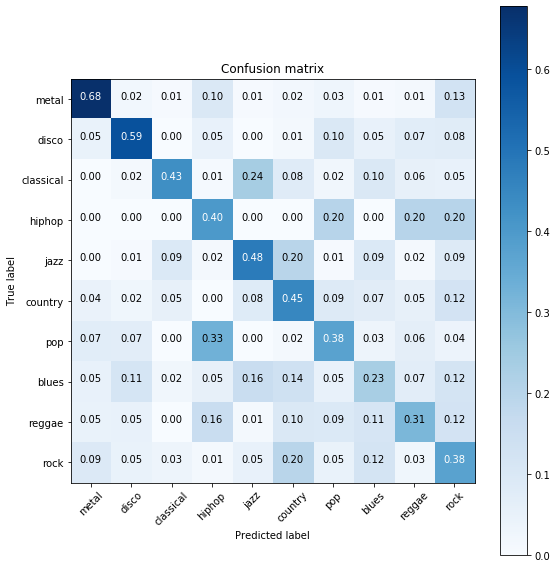

In [78]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys() # extraer nombres de categorías

plt.figure(figsize=(8,8)) 
plot_confusion_matrix(cm, keys, normalize=True)

los labels Predicted y True estan intercambiados (esto se arregla en la memoria)

### tempo

In [96]:
t_preds = model.predict(X_test)[1]

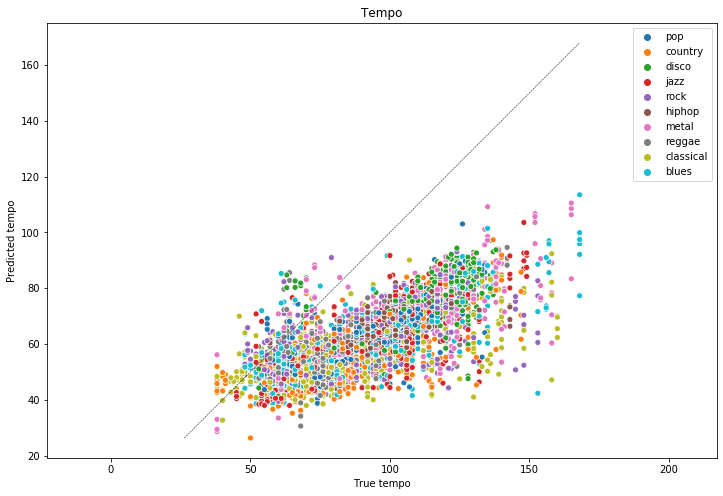

In [128]:
genres_true = [list(keys)[i] for i in y_orig]
plt.figure(figsize=(12,8)) 
sns.scatterplot(y2_test,t_preds.reshape(-1,),hue=genres_true)
min_t = min(np.min(y2_test),np.min(t_preds))
max_t = max(np.max(y2_test),np.max(t_preds))
plt.plot([min_t, max_t],[min_t,max_t],'k--',linewidth=0.5)
plt.axis('equal')
plt.xlabel("True tempo")
plt.ylabel("Predicted tempo")
plt.title("Tempo")
plt.show()

Los puntos de predicción deberían estar sobre la diagonal pintada idealmente.

## Save the model
En el caso de que quisieramos guardar el modelo con sus pesos entrenados para uso futuro podemos utilizar la función `save()`:

In [ ]:
# Save the model
# model.save('../models/nbs_deeplearning.h5')